In [1]:
import os
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
from google.colab import drive
from google.colab import files
import matplotlib.pyplot as plt

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Define Bi-MSAAE Model
class MultiScaleEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.branch3x3 = nn.Sequential(
            nn.Conv2d(1, 1, kernel_size=3, padding=1),
            nn.Conv2d(1, 32, kernel_size=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.branch5x5 = nn.Sequential(
            nn.Conv2d(1, 1, kernel_size=5, padding=2),
            nn.Conv2d(1, 32, kernel_size=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        f1 = self.branch3x3(x)
        f2 = self.branch5x5(x)
        return torch.cat([f1, f2], dim=1)

class NoiseGateModule(nn.Module):
    def __init__(self, in_channels=64):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        mask = self.conv(x)
        mask = self.sigmoid(mask)
        return x * mask

class ChannelAttentionBlock(nn.Module):
    def __init__(self, in_channels=64):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.conv = nn.Conv2d(in_channels * 2, in_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.avg_pool(x)
        max_out = self.max_pool(x)
        pooled = torch.cat([avg_out, max_out], dim=1)
        attn = self.conv(pooled)
        attn = self.sigmoid(attn)
        return x * attn

class DualHeadDecoder(nn.Module):
    def __init__(self, in_channels=64):
        super().__init__()
        self.structural_head = nn.Sequential(
            nn.Conv2d(in_channels, 1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1)
        )
        self.texture_head = nn.Sequential(
            nn.Conv2d(in_channels, 1, kernel_size=5, padding=2),
            nn.BatchNorm2d(1)
        )
        self.alpha = 0.6

    def forward(self, x):
        struct = self.structural_head(x)
        text = self.texture_head(x)
        return self.alpha * struct + (1 - self.alpha) * text

class BiMSAAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = MultiScaleEncoder()
        self.noise_gate = NoiseGateModule()
        self.attention = ChannelAttentionBlock()
        self.decoder = DualHeadDecoder()
        self.skip_conv = nn.Conv2d(64, 64, kernel_size=1)

    def forward(self, x):
        f = self.encoder(x)
        skip = self.skip_conv(f)
        f = self.noise_gate(f)
        f = self.attention(f)
        f = f + skip
        out = self.decoder(f)
        return torch.sigmoid(out)


In [22]:
# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BiMSAAE().to(device)
model_path = '/content/drive/MyDrive/bi_msaae_model_sigma15_48x48.pth'
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model not found at {model_path}")
model.load_state_dict(torch.load(model_path))
model.eval()
print(f"✅ Loaded trained model from {model_path}")

✅ Loaded trained model from /content/drive/MyDrive/bi_msaae_model_sigma15_48x48.pth


In [7]:
# Transform for frames
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((48, 48)),
    transforms.Grayscale(),
    transforms.ToTensor()
])


In [8]:
# Function to add Gaussian noise (sigma=15)
def add_gaussian_noise(frame, sigma=15):
    frame_np = frame.cpu().numpy() if isinstance(frame, torch.Tensor) else frame
    noise = np.random.normal(0, sigma/255.0, frame_np.shape)
    noisy_frame = frame_np + noise
    noisy_frame = np.clip(noisy_frame, 0, 1)
    return noisy_frame


In [9]:
# Upload video
print("Please upload a video file (.mp4, .avi, etc.)")
uploaded = files.upload()
if not uploaded:
    raise ValueError("No video file uploaded")
video_path = list(uploaded.keys())[0]
print(f"Uploaded video: {video_path}")

Please upload a video file (.mp4, .avi, etc.)


Saving 8055708-uhd_3840_2160_30fps (1).mp4 to 8055708-uhd_3840_2160_30fps (1).mp4
Uploaded video: 8055708-uhd_3840_2160_30fps (1).mp4


In [10]:
# Read video
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise ValueError(f"Could not open video file: {video_path}")

In [11]:
# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width = 48  # Output size
height = 48
print(f"🎥 Video Info: {frame_count} frames, {fps:.2f} FPS, output size: {width}x{height}")

🎥 Video Info: 237 frames, 29.97 FPS, output size: 48x48


In [12]:
# Prepare output videos
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
original_out = cv2.VideoWriter(os.path.join(output_dir, 'original_video.mp4'), fourcc, fps, (width, height), isColor=False)
noisy_out = cv2.VideoWriter(os.path.join(output_dir, 'noisy_video_sigma15.mp4'), fourcc, fps, (width, height), isColor=False)
denoised_out = cv2.VideoWriter(os.path.join(output_dir, 'denoised_video.mp4'), fourcc, fps, (width, height), isColor=False)


In [13]:
# Process frames
frame_idx = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to grayscale and resize
    frame_tensor = transform(frame).to(device)

    # Add noise
    noisy_frame = add_gaussian_noise(frame_tensor, sigma=15)
    noisy_tensor = torch.tensor(noisy_frame, dtype=torch.float32).to(device)

    # Denoise
    with torch.no_grad():
        denoised_tensor = model(noisy_tensor.unsqueeze(0)).squeeze(0)

    # Convert tensors to OpenCV format (uint8, 48x48, grayscale)
    original_frame = (frame_tensor.cpu().numpy().squeeze() * 255).astype(np.uint8)
    noisy_frame = (noisy_frame.squeeze() * 255).astype(np.uint8)
    denoised_frame = (denoised_tensor.cpu().numpy().squeeze() * 255).astype(np.uint8)

    # Write frames to videos
    original_out.write(original_frame)
    noisy_out.write(noisy_frame)
    denoised_out.write(denoised_frame)

    frame_idx += 1
    if frame_idx % 100 == 0:
        print(f"📊 Processed {frame_idx}/{frame_count} frames")

📊 Processed 100/237 frames
📊 Processed 200/237 frames


In [14]:
# Release resources
cap.release()
original_out.release()
noisy_out.release()
denoised_out.release()
print(f"✅ Processing complete. Videos saved to {output_dir}:")
print(f"  - original_video.mp4")
print(f"  - noisy_video_sigma15.mp4")
print(f"  - denoised_video.mp4")

✅ Processing complete. Videos saved to /content/drive/MyDrive/denoised_samples_grayscale_sigma15:
  - original_video.mp4
  - noisy_video_sigma15.mp4
  - denoised_video.mp4


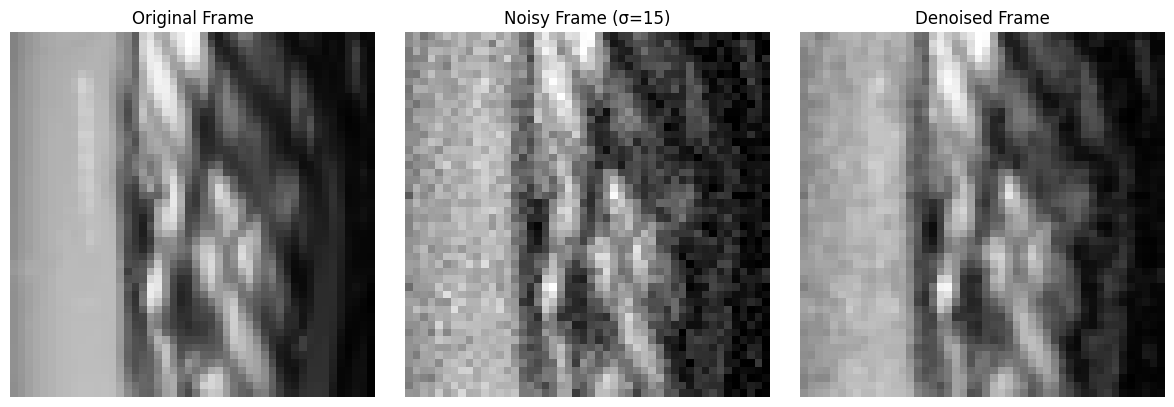

📷 Sample frame comparison saved to /content/drive/MyDrive/denoised_samples_grayscale_sigma15/sample_frame_comparison.jpg


In [15]:

# Display sample frame (first frame for visualization)
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
if ret:
    frame_tensor = transform(frame).to(device)
    noisy_frame = add_gaussian_noise(frame_tensor, sigma=15)
    with torch.no_grad():
        denoised_tensor = model(torch.tensor(noisy_frame, dtype=torch.float32).unsqueeze(0).to(device)).squeeze(0)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(frame_tensor.cpu().squeeze(), cmap='gray')
    plt.title('Original Frame')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(noisy_frame.squeeze(), cmap='gray')
    plt.title('Noisy Frame (σ=15)')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(denoised_tensor.cpu().squeeze(), cmap='gray')
    plt.title('Denoised Frame')
    plt.axis('off')
    plt.tight_layout()
    sample_path = os.path.join(output_dir, 'sample_frame_comparison.jpg')
    plt.savefig(sample_path)
    plt.show()
    print(f"📷 Sample frame comparison saved to {sample_path}")

cap.release()